<a href="https://colab.research.google.com/github/Enrico-Call/RL-AKI/blob/main/3_Data_Preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/AmsterdamUMC/AmsterdamUMCdb/blob/master/img/logo_amds.png?raw=1" alt="Logo" width=128px/>

# VUmc Research Project - Reinforcement Learning for Sepsis Prevention
# Data Preparation

AmsterdamUMCdb version 1.0.2 March 2020  
Copyright &copy; 2003-2022 Amsterdam UMC - Amsterdam Medical Data Science

### 1. Load Data and Set Up Environment

In [13]:
from google.colab import drive

import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/MyDrive/MLRFH')

aggregated = pd.read_csv('aggregated.csv')

Mounted at /content/drive


## 2. Clustering

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

def k_means_over_instances(dataset, cols, k, max_iters, n_inits):

        # Take the appropriate columns.
        temp_dataset = dataset[cols]
        # Now apply the k-means algorithm
        kmeans = KMeans(n_clusters=k, max_iter=max_iters, n_init=n_inits, random_state=0).fit(temp_dataset)
        # Add the labels to the dataset
        dataset['cluster'] = kmeans.labels_
        # Compute the silhouette and add it as well.
        silhouette_avg = silhouette_score(temp_dataset, kmeans.labels_)
        silhouette_per_inst = silhouette_samples(temp_dataset, kmeans.labels_)
        dataset['silhouette'] = silhouette_per_inst

        return dataset, silhouette_avg

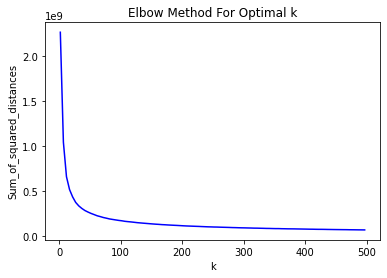

In [15]:
Sum_of_squared_distances = []
K = range(2,500, 5)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(aggregated[['Kreatinine', 'Kreatinine (bloed)', 'KREAT enzym. (bloed)',
       'Urine', 'Chloor (bloed)', 'Natrium (bloed)',
       'Kalium (bloed)', 'HCO3', 'Natrium', 'Natrium Astrup',
       'Kalium Astrup', 'Chloor Astrup', 'Chloor', 'Kalium',
       'Act.HCO3 (bloed)', 'Na (onv.ISE) (bloed)', 'K (onv.ISE) (bloed)',
       'Cl (onv.ISE) (bloed)', 'Niet invasieve bloeddruk gemiddeld',
       'ABP gemiddeld II', 'ABP gemiddeld', 'agegroup', 'gender',
       'weightgroup', 'heightgroup']])
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'b-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [16]:
# Use k=50 based on previous runs

new_d, sil = k_means_over_instances(aggregated, ['Kreatinine', 'Kreatinine (bloed)', 'KREAT enzym. (bloed)',
       'Urine', 'Chloor (bloed)', 'Natrium (bloed)',
       'Kalium (bloed)', 'HCO3', 'Natrium', 'Natrium Astrup',
       'Kalium Astrup', 'Chloor Astrup', 'Chloor', 'Kalium',
       'Act.HCO3 (bloed)', 'Na (onv.ISE) (bloed)', 'K (onv.ISE) (bloed)',
       'Cl (onv.ISE) (bloed)', 'Niet invasieve bloeddruk gemiddeld',
       'ABP gemiddeld II', 'ABP gemiddeld', 'agegroup', 'gender',
       'weightgroup', 'heightgroup'], 50, 20, 10)

## 3. Bin Values

In [17]:
# Binning Values

binsv = [-np.inf, 0, 40, np.inf]
binsf = [-np.inf, 0.5, 1, np.inf]
labels = [0, 1, 2]
aggregated['vasop'] = pd.cut(aggregated['vasops_sum'], bins=binsv, labels=labels)
aggregated['fluid'] = pd.cut(aggregated['fluid_sum'], bins=binsf, labels=labels)

In [19]:
# 0 = no vasop, no fluid
# 1 = no vasop, low fluid
# 2 = no vasop, high fluid
# 3 = low vasop, no fluid
# 4 = low vasop, low fluid
# 5 = low vasop, high fluid
# 6 = high vasop, no fluid
# 7 = high vasop, low fluid
# 8 = high vasop, high fluid

act = []

for v, f in zip(aggregated['vasop'], aggregated['fluid']): 
  if v == 0 and f == 0: act.append('0')
  elif v == 0 and f == 1: act.append('1')
  elif v == 0 and f == 2: act.append('2')
  elif v == 1 and f == 0: act.append('3')
  elif v == 1 and f == 1: act.append('4')
  elif v == 1 and f == 2: act.append('5')
  elif v == 2 and f == 0: act.append('6')
  elif v == 2 and f == 1: act.append('7')
  elif v == 2 and f == 2: act.append('8')

aggregated['action'] = act

aggregated['reward'] = -aggregated['aki_stage']

aggregated['next'] = aggregated['cluster'].shift(-1)

final = aggregated.dropna()
